# Upper envelope

**Table of contents**<a id='toc0_'></a>    
- 1. [Model](#toc1_)    
- 2. [Algorithm](#toc2_)    
- 3. [Setup](#toc3_)    
- 4. [Next-period functions](#toc4_)    
  - 4.1. [Figures](#toc4_1_)    
- 5. [EGM](#toc5_)    
  - 5.1. [Figures](#toc5_1_)    
- 6. [Upper envelope](#toc6_)    
  - 6.1. [Figures](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to use the **upperenvelope** module from the **consav** package.

## 1. <a id='toc1_'></a>[Model](#toc0_)

Consider a **standard consumption-saving** model

\begin{align}
v_{t}(m_{t})&=\max_{c_{t}}\frac{c_{t}^{1-\rho}}{1-\rho}+\beta v_{t+1}(m_{t+1})
\end{align}

where


\begin{align}
a_{t}	&=m_{t}-c_{t} \\
m_{t+1}	&=Ra_{t}+y \\
\end{align}

The **Euler equation** is

\begin{align}
c_{t}^{-\rho} &=\beta Rc_{t+1}^{-\rho}
\end{align}

Assume that the **t+1 consumption and value functions** are given by

\begin{align}
c_{t+1}(m_{t}) &= \sqrt{m_{t}}-\eta_{c} \cdot 1\{m_{t}\geq\underline{m}\} \\
v_{t+1}(m_{t}) &= \sqrt{m_{t}}+\eta_{v}\sqrt{m_{t}-\underline{m}} \cdot 1\{m_{t}\geq\underline{m}\}
\end{align}

This **notebook** shows how to find the **t consumption and value function** using an **upper envelope** code despite the **kink** in the next-period value function.

## 2. <a id='toc2_'></a>[Algorithm](#toc0_)

1. Specify an increasing grid of $m_t$ indexed by $j$, such as {${m_1,m_2,...,m_{\#_m}}$} <br>
2. Specify an increasing grid of $a_t $ indexed by $i$, such as {${a^1,a^2,...,a^{\#_a}}$} <br>
3. For each $i$ compute (using linear interpolation):<br>

  a. Post-decision value function: $w^i = \beta \breve{v}_{t+1}(Ra^i+y)$ <br>
  b. Post-decision marginal value of cash: $q^i = \beta R\breve{c}_{t+1}(Ra^i+y)^{-\rho}$ <br>
  c. Consumption: $c_i = (q^i)^{-1/\rho}$ <br>
  d. Cash-on-hand: $m^i = a^i + c^i$ <br>
  
4. For each $j$: <br>

  a. Constraint: If $m_j < m^1$ then set $c_j = m_j$ <br>
  b. Find best segment: If $m_j \geq m^1$ then set $c_j =c_j^{i^{\star}(j)} $ where <br>

  $$
  \begin{align}
  c_j^i=c_j^i+\frac{c^{i+1}-c^i}{m^{i+1}-m^i}(m_j-m^i)
  \end{align}
  $$
  
  and

  $$
  \begin{align}
  i^{\star}(j)=\arg\max_{i\in\{1,\dots\#_{A}-1\}}\frac{(c_{j}^{i})^{1-\rho}}{1-\rho}+\beta w_{j}^{i} \\
  \end{align}
  $$
  
  subject to
  
  $$
  \begin{align}
  m_{j} &\in [m^{i},m^{i+1}] \\
  a_{j}^{i} &= m_{j}-c_{j}^{i} \\
  w_{j}^{i} &= w^{i}+\frac{w^{i+1}-w^{i}}{a^{i+1}-a^{i}}(a_{j}^{i}-a^{i})
  \end{align}
  $$


## 3. <a id='toc3_'></a>[Setup](#toc0_)

In [1]:
import numpy as np
from numba import njit

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

Choose parameters and create grids:

In [2]:
def setup():
    
    par = dict()
    
    # a. model parameters
    par['beta'] = 0.96
    par['rho'] = 2
    par['R'] = 1.02
    par['y'] = 1
    
    # b. cash-on-hand (exogenous grid)
    par['Nm'] = 10000
    par['m_max'] = 10
    
    # c. end-of-period assets (exogenous grid)
    par['Na'] = 1000
    par['a_max'] = 10
    
    # d. next-period consumption and value function
    par['eta_v'] = 0.5
    par['eta_c'] = 0.5
    par['x_ubar'] = 5
    
    return par

def create_grids(par):
    
    par['grid_a'] = np.linspace(0,par['a_max'],par['Na'])
    par['grid_m'] = np.linspace(1e-8,par['m_max'],par['Nm'])
    
    return par

par = setup()
par = create_grids(par)

## 4. <a id='toc4_'></a>[Next-period functions](#toc0_)

Calculate the next-period consumption and value functions:

In [3]:
sol = dict()
    
# a. consumption function    
sol['c_next'] = np.sqrt(par['grid_m']) - par['eta_c']*(par['grid_m'] >= par['x_ubar']);

# b. value function
sol['v_next'] = np.sqrt(par['grid_m']) + par['eta_v']*np.sqrt(np.fmax(par['grid_m']-par['x_ubar'],0))*(par['grid_m'] >= par['x_ubar'])

### 4.1. <a id='toc4_1_'></a>[Figures](#toc0_)

Plot them to see the jump in consumption and the kink in the value function.

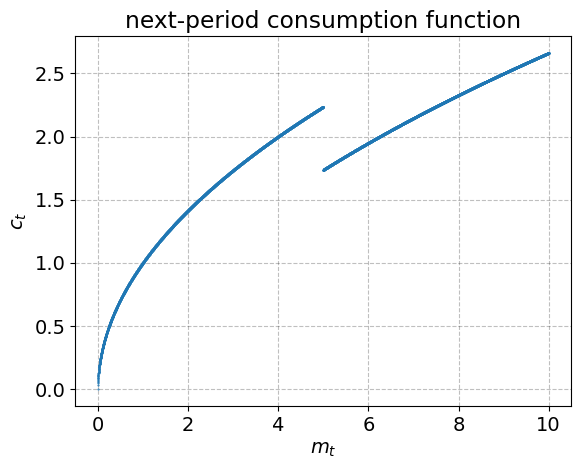

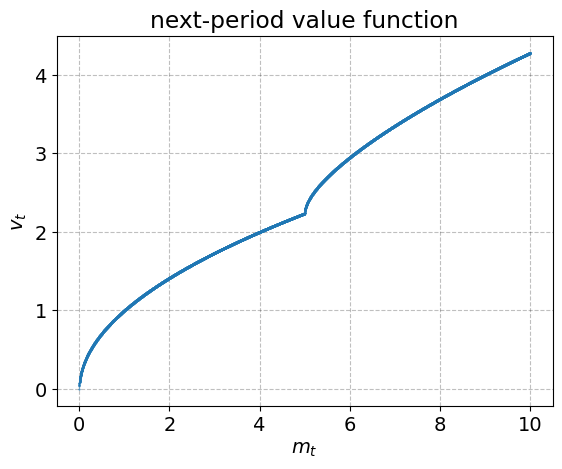

In [4]:
# a. next-period consumption function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par['grid_m'],sol['c_next'],'o',ms=0.5)
    
ax.set_title('next-period consumption function')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')

# b. next-period value function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par['grid_m'],sol['v_next'],'o',ms=0.5)
    
ax.set_title('next-period value function')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$v_t$');

## 5. <a id='toc5_'></a>[EGM](#toc0_)

In [5]:
from consav import linear_interp # linear interpolation

Apply the EGM algorithm.

In [6]:
@njit
def u(c,rho):
    return c**(1-2)/(1-2)
    
def marg_u(c,par):
    return c**(-par['rho'])

def inv_marg_u(u,par):
    return u**(-1.0/par['rho'])
    
def EGM(par,sol):

    # a. next-period cash-on-hand
    m_plus = par['R']*par['grid_a'] + par['y']

    # b. post-decision value function
    sol['w_vec'] = np.empty(m_plus.size)
    linear_interp.interp_1d_vec(par['grid_m'],sol['v_next'],m_plus,sol['w_vec'])
    
    # c. post-decision marginal value of cash
    c_next_interp = np.empty(m_plus.size)
    linear_interp.interp_1d_vec(par['grid_m'],sol['c_next'],m_plus,c_next_interp)
    q = par['beta']*par['R']*marg_u(c_next_interp,par)

    # d. EGM
    sol['c_vec'] = inv_marg_u(q,par)
    sol['m_vec'] = par['grid_a'] + sol['c_vec']
    
    return sol
    
sol = EGM(par,sol)

### 5.1. <a id='toc5_1_'></a>[Figures](#toc0_)

Plot the result of the EGM algorithm to see that the its does not define a consumption function.

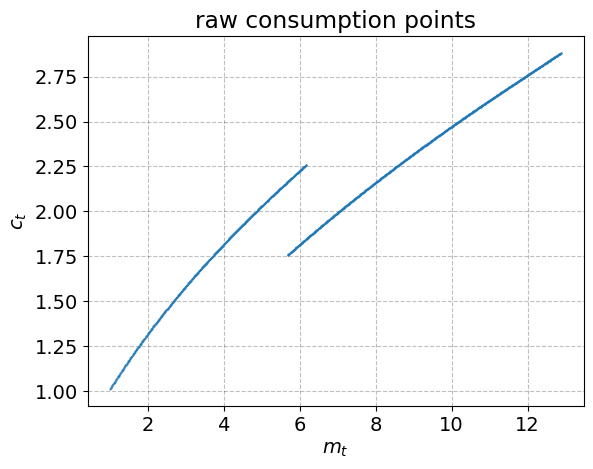

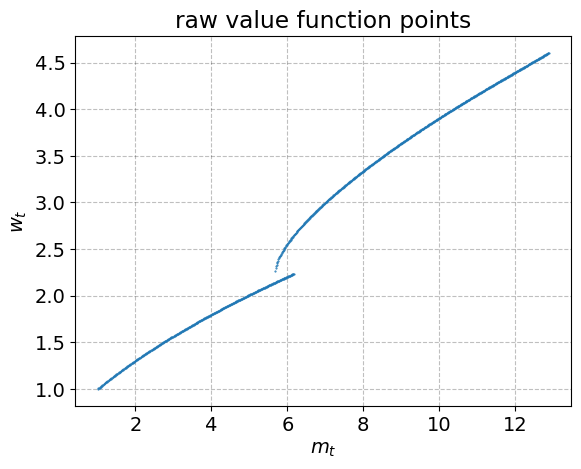

In [7]:
# a. raw consumption function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(sol['m_vec'],sol['c_vec'],'o',ms=0.5)
    
ax.set_title('raw consumption points')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')

# b. raw value function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(sol['m_vec'],sol['w_vec'],'o',ms=0.5)
    
ax.set_title('raw value function points')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$w_t$');

## 6. <a id='toc6_'></a>[Upper envelope](#toc0_)

In [8]:
from consav import upperenvelope

# a. create
myupperenvelope = upperenvelope.create(u) # where is the utility function

# b. apply
c_ast_vec = np.empty(par['grid_m'].size) # output
v_ast_vec = np.empty(par['grid_m'].size) # output
myupperenvelope(par['grid_a'],sol['m_vec'],sol['c_vec'],sol['w_vec'],par['grid_m'],c_ast_vec,v_ast_vec,par['rho'])

### 6.1. <a id='toc6_1_'></a>[Figures](#toc0_)

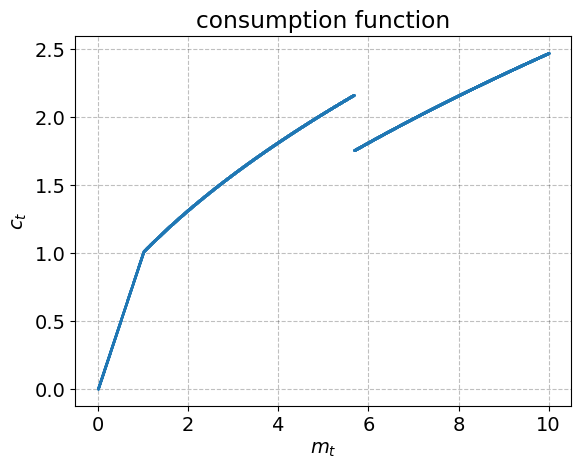

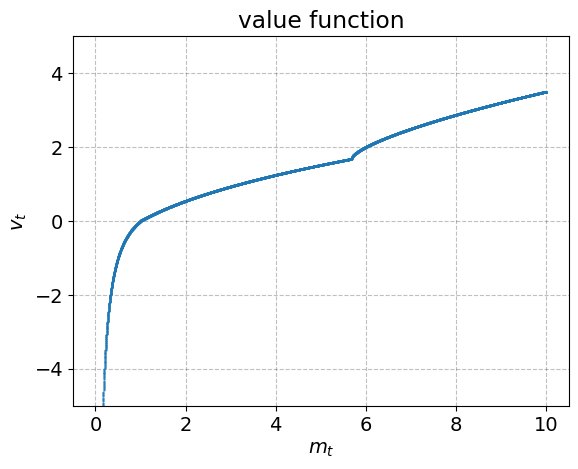

In [9]:
# a. consumption function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par['grid_m'],c_ast_vec,'o',ms=0.5)
    
ax.set_title('consumption function')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')

# b. value function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par['grid_m'],v_ast_vec,'o',ms=0.5)
    
ax.set_title('value function')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$v_t$')

ax.set_ylim((-5,5));